In [21]:
import udma
import numpy as np
import fxpmath as fx
import matplotlib.pyplot as plt
from tqdm import trange

In [22]:
cb = udma.UDMA_CLASS('192.168.1.10', 7)
cb.connect()
cb.log(0)

[(5,), 0]

In [23]:
cb.write_reg(0, 1)
cb.write_reg(0, 0)

[(1, 0), 0]

In [24]:
for i in trange(1):
    x = np.random.randint(0,32767)
    cb.write_fifo(1, [x])
    #print(x)
    while (cb.read_reg(1)[1][0] & 1 == 0):
        pass

100%|██████████| 1/1 [00:00<00:00, 24.15it/s]


In [25]:
# AGENTS
class Agent:
    def __init__(self, n_anctions, alfa):
        self.alfa = alfa
        self.n_anctions = n_anctions
        self.indices = np.arange(n_anctions)
        self.prob = np.ones(self.n_anctions) / self.n_anctions
        #self.prob = fx.Fxp(np.ones(self.n_anctions) / self.n_anctions, signed=True, n_word=25, n_frac=22)
    def step(self, action, reward):    
        self.prob = (1 - self.alfa * reward) * self.prob
        self.prob[action] += self.alfa * reward
    def act(self):
        #aux0 = np.array(self.prob)
        #aux1 = np.sum(aux0)
        #p_aux = aux0/aux1
        return np.random.choice(self.indices, p=self.prob)

In [26]:
# QUANTUM
def general1qgate(a,b,c):
    u2 = np.matrix([[             np.cos(a/2), -np.exp(1j*c)    *np.sin(a/2)],
                    [np.exp(1j*b)*np.sin(a/2),  np.exp(1j*(b+c))*np.cos(a/2)]])
    return u2

def Numpy_QGT_Nplayers(tipo, J_init, J_dg):
    n_p = len(tipo)
    strategies_gate = 1
    for i in range(n_p):      
      players_gate = general1qgate(tipo[i][0], tipo[i][1], tipo[i][2])
      strategies_gate = np.kron(strategies_gate, players_gate)
    outputstate = J_dg * strategies_gate * J_init
    prob = np.power(np.abs(outputstate),2)
    return prob

def matrix_reward(rotat, J_init, J_dg):  
  prob = Numpy_QGT_Nplayers(rotat, J_init, J_dg)
  reward_g = prob.transpose() * game
  reward_h = reward_g.tolist()[0]
  return reward_h

# GAME
def int_to_binary(s,m):
    if s == 0:
        return "0 " * m
    binary1 = ""
    while s > 0:
        binary1 = str(s % 2) + " " + binary1
        s = s // 2
    binary2 = "0 " * (m - len(binary1)//2) + binary1
    return binary2

def platonia_matrix(n): 
  mm = np.zeros([2**n,n])
  for i in range(n):
    mm[2**i][n-i-1] = 10
  return  mm

def minority_matrix(n):
  mm = np.zeros([2**n,n])
  for i in range(2**n):
    numpy_data = np.fromstring(int_to_binary(i,n), dtype=int, sep=' ')
    if (np.count_nonzero(numpy_data == 0) > np.count_nonzero(numpy_data == 1)):
      mm[i] = np.where(numpy_data == 1, 10, 0)
    elif (np.count_nonzero(numpy_data == 0) < np.count_nonzero(numpy_data == 1)):
      mm[i] = np.where(numpy_data == 0, 10, 0)
  return  mm

In [27]:
# MAIN
players     = 2
alfa        = 1/(2**11)
t_max       = 100000
window1     = 1000
actions     = [0 for i in range(players)]
rotat       = np.zeros([len(actions), 3])
rewards     = np.zeros((players, t_max))
rewards_avg = np.zeros(rewards.shape)
game        = platonia_matrix(players)

N_SIZE = 3
A_MAX  = 2 * np.pi
angulos = np.arange(0, A_MAX, A_MAX / np.power(2, N_SIZE))
all_actions = [(rx,ry,0) for rx in angulos for ry in angulos]
#all_actions = [(rx,ry,rz) for rx in angulos for ry in angulos for rz in angulos]
gamma = np.pi/2
print("Players = {}. Learning Rate = {}. Gamma = {:.6f}. Number of actions = {}. \n {}".format(players, alfa, gamma, len(all_actions), game))

init_mat = np.matrix([[1] if i==0 else [0] for i in range(2**players)])
I_f = np.array(np.eye(2**players))
X_f = np.array(np.flip(np.eye(2**players),0))
J = np.matrix(np.cos(gamma/2) * I_f + 1j * np.sin(gamma/2) * X_f)
J_dg = J.H
J_init = J * init_mat

Players = 2. Learning Rate = 0.00048828125. Gamma = 1.570796. Number of actions = 64. 
 [[ 0.  0.]
 [ 0. 10.]
 [10.  0.]
 [ 0.  0.]]


In [28]:
# Initialization
agents = []
hw_data = []                            # extra
for i in range(players-1):
    agents.append(Agent(n_anctions=len(all_actions), alfa=alfa))
    actions[i] = agents[i].act()
    rotat[i] = all_actions[actions[i]]
##############################
i = players-1
cb.write_reg(0, 1)
cb.write_reg(0, 0)
actions[i] = cb.read_reg(0)[1][0]       #np.random.randint(0, 512)
rotat[i] = all_actions[actions[i]]
##############################
reward = matrix_reward(rotat, J_init, J_dg)
print(reward)

[0.7322330470336319, 0.7322330470336319]


In [29]:
# Iterations
for t in trange(t_max):
    # Update
    for i in range(players-1):
        rewards[i,t] = reward[i]
        if t<window1:
            rewards_avg[i,t] = np.mean(rewards[i,0:t+1])
        else:
            rewards_avg[i,t] = np.mean(rewards[i,t-window1:t+1])
        agents[i].step(actions[i], reward[i])
        actions[i] = agents[i].act()
        rotat[i] = all_actions[actions[i]]    
    ##############################
    i = players-1
    rewards[i,t] = reward[i]
    if t<window1:
        rewards_avg[i,t] = np.mean(rewards[i,0:t+1])
    else:
        rewards_avg[i,t] = np.mean(rewards[i,t-window1:t+1])    
    
    r_bin = fx.Fxp(reward[i], signed=True, n_word=16, n_frac=11)
    r_int = int(r_bin.bin(), 2)
    cb.write_fifo(1, [r_int])
    while(cb.read_reg(1)[1][0] & 1 == 0):
        pass
    actions[i] = cb.read_reg(0)[1][0]
    rotat[i] = all_actions[actions[i]]
    ##############################
    reward = matrix_reward(rotat, J_init, J_dg)
    if (t % 1000) == 0:
        print("R_SW = {} | R_HW = {}".format(rewards_avg[0,t], rewards_avg[1,t]))

  0%|          | 0/100000 [00:00<?, ?it/s]

R_SW = 0.7322330470336319 | R_HW = 0.7322330470336319


  1%|          | 1002/100000 [01:23<2:17:11, 12.03it/s]

R_SW = 2.4451284646641436 | R_HW = 2.5440980375861453


  2%|▏         | 2002/100000 [02:47<2:17:04, 11.92it/s]

R_SW = 2.430974463940921 | R_HW = 2.5200060130871274


  3%|▎         | 3002/100000 [04:10<2:13:22, 12.12it/s]

R_SW = 2.6037978525768732 | R_HW = 2.4225362030607007


  4%|▍         | 4002/100000 [05:34<2:15:58, 11.77it/s]

R_SW = 2.5642295564966844 | R_HW = 2.392455893676874


  5%|▌         | 5002/100000 [06:58<2:11:42, 12.02it/s]

R_SW = 2.550748764119368 | R_HW = 2.3163511274001225


  6%|▌         | 6002/100000 [08:21<2:18:36, 11.30it/s]

R_SW = 2.545095777188073 | R_HW = 2.575567830451751


  7%|▋         | 7002/100000 [09:45<2:13:39, 11.60it/s]

R_SW = 2.457412492006923 | R_HW = 2.551439046148134


  8%|▊         | 8002/100000 [11:09<2:07:07, 12.06it/s]

R_SW = 2.5303617738498816 | R_HW = 2.6239078380924283


  9%|▉         | 9002/100000 [12:33<2:07:05, 11.93it/s]

R_SW = 2.809991460278103 | R_HW = 2.6339453745845294


 10%|█         | 10002/100000 [13:56<2:06:33, 11.85it/s]

R_SW = 3.087008905082901 | R_HW = 2.9113608702545477


 11%|█         | 11002/100000 [15:20<2:03:10, 12.04it/s]

R_SW = 3.52675129639309 | R_HW = 3.581800323766573


 12%|█▏        | 12002/100000 [16:44<2:01:21, 12.08it/s]

R_SW = 4.016091366016954 | R_HW = 4.042948978343159


 13%|█▎        | 13002/100000 [18:07<2:01:32, 11.93it/s]

R_SW = 4.133357397000405 | R_HW = 4.304641650497305


 14%|█▍        | 14002/100000 [19:31<1:59:46, 11.97it/s]

R_SW = 4.192308636762784 | R_HW = 4.383529843449736


 15%|█▌        | 15002/100000 [20:55<1:59:35, 11.85it/s]

R_SW = 4.471395080380636 | R_HW = 4.33923908741635


 16%|█▌        | 16002/100000 [22:18<1:58:27, 11.82it/s]

R_SW = 4.323968148253158 | R_HW = 5.001985477671996


 17%|█▋        | 17002/100000 [23:42<1:54:25, 12.09it/s]

R_SW = 4.904122841658103 | R_HW = 4.496370422297643


 18%|█▊        | 18002/100000 [25:06<1:53:53, 12.00it/s]

R_SW = 4.4313310679921685 | R_HW = 4.722092165626212


 19%|█▉        | 19002/100000 [26:29<1:53:51, 11.86it/s]

R_SW = 5.066958832742922 | R_HW = 3.9855907072072916


 20%|██        | 20002/100000 [27:53<1:50:34, 12.06it/s]

R_SW = 4.353877272584728 | R_HW = 4.873302111304543


 21%|██        | 21002/100000 [29:17<1:50:50, 11.88it/s]

R_SW = 3.9260434732546963 | R_HW = 5.4346241759886675


 22%|██▏       | 22002/100000 [30:41<1:48:38, 11.97it/s]

R_SW = 5.269220857343639 | R_HW = 3.931875482554881


 23%|██▎       | 23002/100000 [32:04<1:46:37, 12.04it/s]

R_SW = 4.067931075469184 | R_HW = 4.72987843461353


 24%|██▍       | 24002/100000 [33:28<1:46:31, 11.89it/s]

R_SW = 4.357374045015421 | R_HW = 4.2954511198422445


 25%|██▌       | 25002/100000 [34:52<1:44:05, 12.01it/s]

R_SW = 4.321603988895701 | R_HW = 4.814263207630964


 26%|██▌       | 26002/100000 [36:16<1:42:32, 12.03it/s]

R_SW = 4.91863259162221 | R_HW = 4.828769896932543


 27%|██▋       | 27002/100000 [37:40<1:40:48, 12.07it/s]

R_SW = 4.562398728062467 | R_HW = 4.701961728823288


 28%|██▊       | 28002/100000 [39:03<1:41:03, 11.87it/s]

R_SW = 3.804633585883421 | R_HW = 4.957561826722215


 29%|██▉       | 29002/100000 [40:27<1:42:05, 11.59it/s]

R_SW = 5.811893010222328 | R_HW = 3.0538206377673727


 30%|███       | 30002/100000 [41:51<1:37:13, 12.00it/s]

R_SW = 4.819131624694943 | R_HW = 4.567264084463918


 31%|███       | 31002/100000 [43:15<1:36:39, 11.90it/s]

R_SW = 4.0519430960044875 | R_HW = 5.398218753435255


 32%|███▏      | 32002/100000 [44:38<1:33:37, 12.10it/s]

R_SW = 4.550487840585413 | R_HW = 4.810326847876347


 33%|███▎      | 33002/100000 [46:02<1:33:23, 11.96it/s]

R_SW = 4.90063651898292 | R_HW = 4.36518694099381


 34%|███▍      | 34002/100000 [47:26<1:32:17, 11.92it/s]

R_SW = 5.3864705798098615 | R_HW = 4.008348163819605


 35%|███▌      | 35002/100000 [48:50<1:30:08, 12.02it/s]

R_SW = 5.445421819572242 | R_HW = 4.038138089313131


 36%|███▌      | 36002/100000 [50:13<1:28:58, 11.99it/s]

R_SW = 5.508982627435143 | R_HW = 4.101858550365166


 37%|███▋      | 37002/100000 [51:37<1:27:53, 11.95it/s]

R_SW = 4.289033566107354 | R_HW = 4.964228861772666


 38%|███▊      | 38002/100000 [53:01<1:25:54, 12.03it/s]

R_SW = 5.094970143313697 | R_HW = 4.0520990546471305


 39%|███▉      | 39002/100000 [54:24<1:24:37, 12.01it/s]

R_SW = 4.738714746358971 | R_HW = 4.850181385076695


 40%|████      | 40002/100000 [55:48<1:24:08, 11.88it/s]

R_SW = 5.607398190849284 | R_HW = 4.055150118428845


 41%|████      | 41002/100000 [57:12<1:21:43, 12.03it/s]

R_SW = 4.078649974565806 | R_HW = 5.027645242856049


 42%|████▏     | 42002/100000 [58:35<1:20:06, 12.07it/s]

R_SW = 5.178226894251687 | R_HW = 3.9566793224776493


 43%|████▎     | 43002/100000 [59:59<1:19:20, 11.97it/s]

R_SW = 4.376283887891931 | R_HW = 5.270422399032283


 44%|████▍     | 44002/100000 [1:01:23<1:17:33, 12.03it/s]

R_SW = 5.178330866680115 | R_HW = 4.543698546034393


 45%|████▌     | 45002/100000 [1:02:46<1:16:40, 11.95it/s]

R_SW = 3.8795886654040763 | R_HW = 5.620315289128858


 46%|████▌     | 46002/100000 [1:04:10<1:14:05, 12.15it/s]

R_SW = 4.239195959786329 | R_HW = 5.322154124567611


 47%|████▋     | 47002/100000 [1:05:34<1:13:57, 11.94it/s]

R_SW = 3.9303206727825653 | R_HW = 5.834282868788651


 48%|████▊     | 48002/100000 [1:06:57<1:12:27, 11.96it/s]

R_SW = 3.7708811762465024 | R_HW = 6.100270579319159


 49%|████▉     | 49002/100000 [1:08:21<1:10:55, 11.98it/s]

R_SW = 4.100339866513486 | R_HW = 5.762137842934746


 50%|█████     | 50002/100000 [1:09:44<1:09:46, 11.94it/s]

R_SW = 3.7380434332941026 | R_HW = 6.115050261886195


 51%|█████     | 51002/100000 [1:11:08<1:08:34, 11.91it/s]

R_SW = 3.197261705083228 | R_HW = 6.582326851473002


 52%|█████▏    | 52002/100000 [1:12:32<1:06:14, 12.08it/s]

R_SW = 4.087881276513939 | R_HW = 5.672688239859599


 53%|█████▎    | 53002/100000 [1:13:56<1:05:36, 11.94it/s]

R_SW = 3.4375633403805925 | R_HW = 6.235477002181193


 54%|█████▍    | 54002/100000 [1:15:19<1:03:48, 12.01it/s]

R_SW = 3.5364100199180593 | R_HW = 6.209027442252069


 55%|█████▌    | 55002/100000 [1:16:43<1:03:36, 11.79it/s]

R_SW = 3.7893551263455785 | R_HW = 5.975101376007242


 56%|█████▌    | 56002/100000 [1:18:06<1:01:46, 11.87it/s]

R_SW = 3.767434225814795 | R_HW = 5.904247086084442


 57%|█████▋    | 57002/100000 [1:19:30<1:00:11, 11.91it/s]

R_SW = 3.1203363743001935 | R_HW = 6.321904463962592


 58%|█████▊    | 58002/100000 [1:20:53<58:30, 11.97it/s]  

R_SW = 2.484143833344084 | R_HW = 6.724769545302966


 59%|█████▉    | 59002/100000 [1:22:17<56:58, 11.99it/s]

R_SW = 2.683104864623876 | R_HW = 6.3690161716418885


 60%|██████    | 60002/100000 [1:23:41<55:04, 12.11it/s]

R_SW = 3.414267100670032 | R_HW = 5.790361241132518


 61%|██████    | 61002/100000 [1:25:04<54:20, 11.96it/s]

R_SW = 3.068535271925807 | R_HW = 6.347873533993051


 62%|██████▏   | 62002/100000 [1:26:28<53:30, 11.84it/s]

R_SW = 3.35289557256584 | R_HW = 6.311366751450088


 63%|██████▎   | 63002/100000 [1:27:52<51:10, 12.05it/s]

R_SW = 3.6191332126355573 | R_HW = 6.081453177007954


 64%|██████▍   | 64002/100000 [1:29:15<49:45, 12.06it/s]

R_SW = 3.65631059108555 | R_HW = 5.908467522743991


 65%|██████▌   | 65002/100000 [1:30:39<49:31, 11.78it/s]

R_SW = 3.4829788721705808 | R_HW = 5.988773039558553


 66%|██████▌   | 66002/100000 [1:32:03<47:02, 12.05it/s]

R_SW = 3.09673191185084 | R_HW = 6.160460568798428


 67%|██████▋   | 67002/100000 [1:33:27<45:37, 12.05it/s]

R_SW = 2.4056121547981686 | R_HW = 6.531892617077797


 68%|██████▊   | 68002/100000 [1:34:50<44:43, 11.92it/s]

R_SW = 2.301833988343034 | R_HW = 6.474030475375036


 69%|██████▉   | 69002/100000 [1:36:14<42:49, 12.06it/s]

R_SW = 2.663692998453719 | R_HW = 6.10349741914692


 70%|███████   | 70002/100000 [1:37:38<41:50, 11.95it/s]

R_SW = 2.9581598954829276 | R_HW = 5.968748870680951


 71%|███████   | 71002/100000 [1:39:01<41:31, 11.64it/s]

R_SW = 2.9429554037779324 | R_HW = 6.244116900932902


 72%|███████▏  | 72002/100000 [1:40:25<38:51, 12.01it/s]

R_SW = 2.867100883982374 | R_HW = 6.611966043201642


 73%|███████▎  | 73002/100000 [1:41:49<37:49, 11.90it/s]

R_SW = 3.231567676004359 | R_HW = 6.398543553625466


 74%|███████▍  | 74002/100000 [1:43:13<36:16, 11.95it/s]

R_SW = 3.6337658559841977 | R_HW = 5.980503351291712


 75%|███████▌  | 75002/100000 [1:44:36<34:47, 11.98it/s]

R_SW = 3.3999122272409545 | R_HW = 5.976034515424217


 76%|███████▌  | 76002/100000 [1:46:00<33:39, 11.88it/s]

R_SW = 2.6212543769522836 | R_HW = 6.419015595367274


 77%|███████▋  | 77002/100000 [1:47:24<31:58, 11.99it/s]

R_SW = 2.4475461405670793 | R_HW = 6.426192491028006


 78%|███████▊  | 78002/100000 [1:48:47<30:49, 11.89it/s]

R_SW = 2.5195389023248325 | R_HW = 6.280443578999361


 79%|███████▉  | 79002/100000 [1:50:11<29:13, 11.98it/s]

R_SW = 2.7534471297211667 | R_HW = 6.070800408427548


 80%|████████  | 80002/100000 [1:51:34<27:53, 11.95it/s]

R_SW = 3.0487988744996284 | R_HW = 6.056345257116535


 81%|████████  | 81002/100000 [1:52:58<26:31, 11.94it/s]

R_SW = 3.1480877537998975 | R_HW = 6.296724106569587


 82%|████████▏ | 82002/100000 [1:54:22<25:42, 11.67it/s]

R_SW = 3.3979204425835916 | R_HW = 6.155759642240215


 83%|████████▎ | 83002/100000 [1:55:45<23:47, 11.91it/s]

R_SW = 3.544580960634227 | R_HW = 5.97045504810212


 84%|████████▍ | 84002/100000 [1:57:09<22:02, 12.10it/s]

R_SW = 3.411793744006391 | R_HW = 6.025807073336641


 85%|████████▌ | 85002/100000 [1:58:33<20:47, 12.02it/s]

R_SW = 2.665367640948044 | R_HW = 6.359917316386499


 86%|████████▌ | 86002/100000 [1:59:56<19:30, 11.96it/s]

R_SW = 2.2177239245826352 | R_HW = 6.589824583843265


 87%|████████▋ | 87002/100000 [2:01:20<18:03, 12.00it/s]

R_SW = 2.4345807506197796 | R_HW = 6.254213495790217


 88%|████████▊ | 88002/100000 [2:02:44<16:42, 11.97it/s]

R_SW = 2.952245895372948 | R_HW = 5.705115317976042


 89%|████████▉ | 89002/100000 [2:04:07<15:17, 11.99it/s]

R_SW = 3.272832596197505 | R_HW = 5.602620050135381


 90%|█████████ | 90002/100000 [2:05:31<13:54, 11.98it/s]

R_SW = 2.8018412877912864 | R_HW = 6.57345639236184


 91%|█████████ | 91002/100000 [2:06:55<12:29, 12.00it/s]

R_SW = 2.545876204285247 | R_HW = 7.223220318987325


 92%|█████████▏| 92002/100000 [2:08:18<11:15, 11.84it/s]

R_SW = 3.465252732134222 | R_HW = 6.370890921676435


 93%|█████████▎| 93002/100000 [2:09:42<09:41, 12.03it/s]

R_SW = 3.99962843847333 | R_HW = 5.748986041525575


 94%|█████████▍| 94002/100000 [2:11:06<08:24, 11.90it/s]

R_SW = 3.90331493913035 | R_HW = 5.6593941758861375


 95%|█████████▌| 95002/100000 [2:12:30<06:57, 11.97it/s]

R_SW = 3.085612349450122 | R_HW = 6.151202060353906


 96%|█████████▌| 96002/100000 [2:13:53<05:41, 11.72it/s]

R_SW = 2.425429909150177 | R_HW = 6.521207865346897


 97%|█████████▋| 97002/100000 [2:15:17<04:11, 11.94it/s]

R_SW = 2.3587897489015583 | R_HW = 6.425454682497148


 98%|█████████▊| 98002/100000 [2:16:41<02:45, 12.07it/s]

R_SW = 2.5797021335313635 | R_HW = 6.143096168046339


 99%|█████████▉| 99002/100000 [2:18:04<01:22, 12.10it/s]

R_SW = 2.997953975268465 | R_HW = 5.721208351976782


100%|██████████| 100000/100000 [2:19:27<00:00, 11.95it/s]


Average Reward of Player 0 = 3.137441.
Average Reward of Player 1 = 5.763990.
Performance over all players = 89.01%.


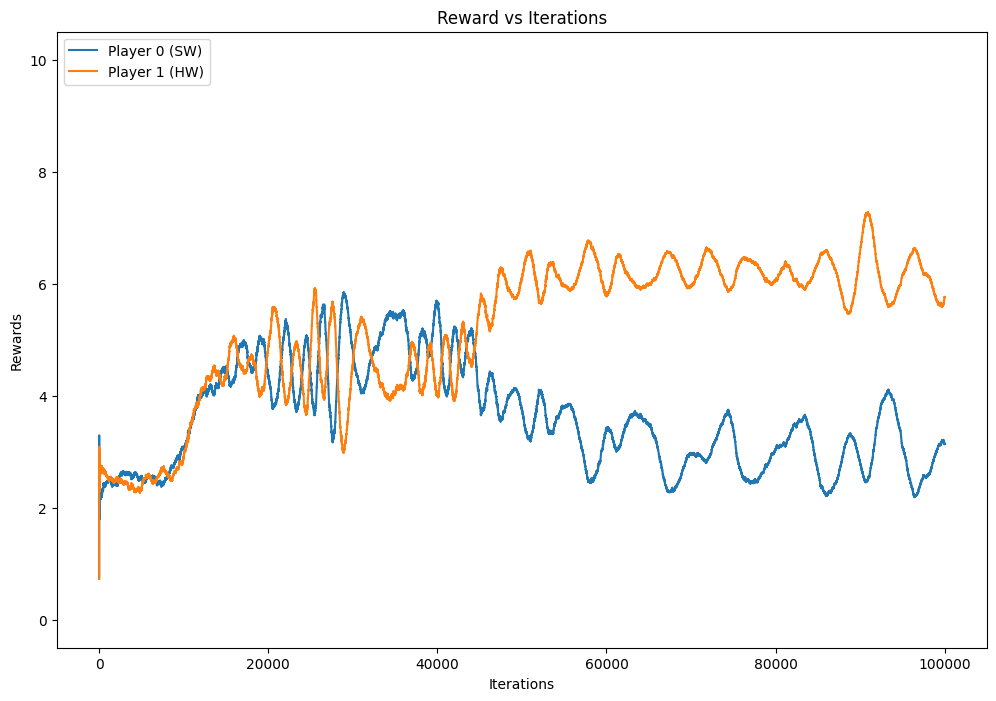

In [30]:
# Plotting
plt.figure(figsize=(12,8))
cumsum = 0
for i in range(players):
    if i!=(players-1):
        plt.plot(rewards_avg[i], label="Player {} (SW)".format(i))
    else:
        plt.plot(rewards_avg[i], label="Player {} (HW)".format(i))
    print("Average Reward of Player {} = {:.6f}.".format(i, rewards_avg[i][-1]))
    cumsum += rewards_avg[i][-1]
print("Performance over all players = {:.2f}%.".format(10 * cumsum / (players // 2)))
plt.ylim(-0.5,10.5)
plt.xlabel("Iterations")
plt.ylabel("Rewards")
plt.title("Reward vs Iterations")
plt.legend(loc="upper left")
plt.show()